In [21]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias
# from ForecastModel.utils.postprocessing import *

import numpy as np
import pandas as pd

import json

# plot styling
plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [22]:
# model class 
class Model:
    def __init__(self, name, model_folder, n_trial=-1, target_name="", feat_hindcast=[], feat_forecast=[], is_external_model= False, is_final_model= False, color="r", ls="-"):
        self.name  = name
        self.color = color
        self.ls    = ls
        self.is_external_model = is_external_model
        
        if is_final_model:
            self.lg_path = model_folder
            self.hp_path = model_folder
            if is_external_model:
                is_external_model
                # do nothing
            else:
                with open(os.path.join(self.lg_path, "features.txt"), "r") as f:
                    dic = json.load(f)
                self.target_name   = dic["target_name"]
                self.feat_hindcast = dic["feat_hindcast"]
                self.feat_forecast = dic["feat_forecast"]
        else:
            self.lg_path = os.path.join(model_folder, "log", f"trial_{n_trial:02d}")
            self.hp_path = os.path.join(model_folder,  "hp", f"trial_{n_trial:02d}")
            self.target_name   = target_name
            self.feat_hindcast = feat_hindcast
            self.feat_forecast = feat_forecast

        
        
         
models = {
    "arima": Model("ARIMA",
                r"rst\ARIMA",
                is_final_model = True,
                is_external_model = True,
                color = "k",
                ls = "--",
                  ),
    "lstm_pbhm": Model("HLSTM-PBHM",
                           r"rst\HLSTM-PBHM",
                           is_final_model = True,
                           color = "#a65628",
                           ls = "-",
                          ),
     "lstm": Model("HLSTM",
                   r"rst\HLSTM",
                   is_final_model = True,
                   color = "#CC79A7",
                   ls = "-",
                 ),
     }
    
    

In [23]:
PLOT_PATH = r"plots"
# DATA_PATH = r"data\data-15min.csv" # REMOVED


In [24]:

def find_best_models(data_lstm, data_arima):
    
    all_best = []
    normalized_arima = []
    normalized_lstm = []
    normalized_hydro = []
    
    all_absolute_errors_arima = []
    all_absolute_errors_lstm = []
    

    for i in range(0,96):
        arima_q0 = data_arima['fc%s' % i].values
        lstm_q0 = data_lstm['q%s' % i].values
        measured_q0 = data_arima['obs%s' % i].values
        
        num_best_arima = 0
        num_best_lstm = 0
        num_best_hydro = 0
        
        all_abs_error = []
        all_abs_error2 = []

        for j in range(0,len(arima_q0)):
            error_arima = abs(measured_q0[j] - arima_q0[j])
            error_lstm = abs(measured_q0[j] - lstm_q0[j])
            
            if error_arima < error_lstm:
                num_best_arima += 1
            if error_lstm < error_arima:
                num_best_lstm += 1
                
            
            all_abs_error.append(error_arima)
            all_abs_error2.append(error_lstm)

        all_absolute_errors_arima.append(all_abs_error)
        all_absolute_errors_lstm.append(all_abs_error2)

        list_best = [num_best_arima, num_best_lstm]
        
    
        all_best.append(list_best)
    
        normalized_arima.append(num_best_arima / (num_best_arima + num_best_lstm))
        normalized_lstm.append(num_best_lstm / (num_best_arima + num_best_lstm))
        normalized_hydro.append(num_best_hydro / (num_best_arima + num_best_lstm))
    
    return all_best, np.asarray(normalized_arima), np.asarray(normalized_lstm), all_absolute_errors_arima,all_absolute_errors_lstm


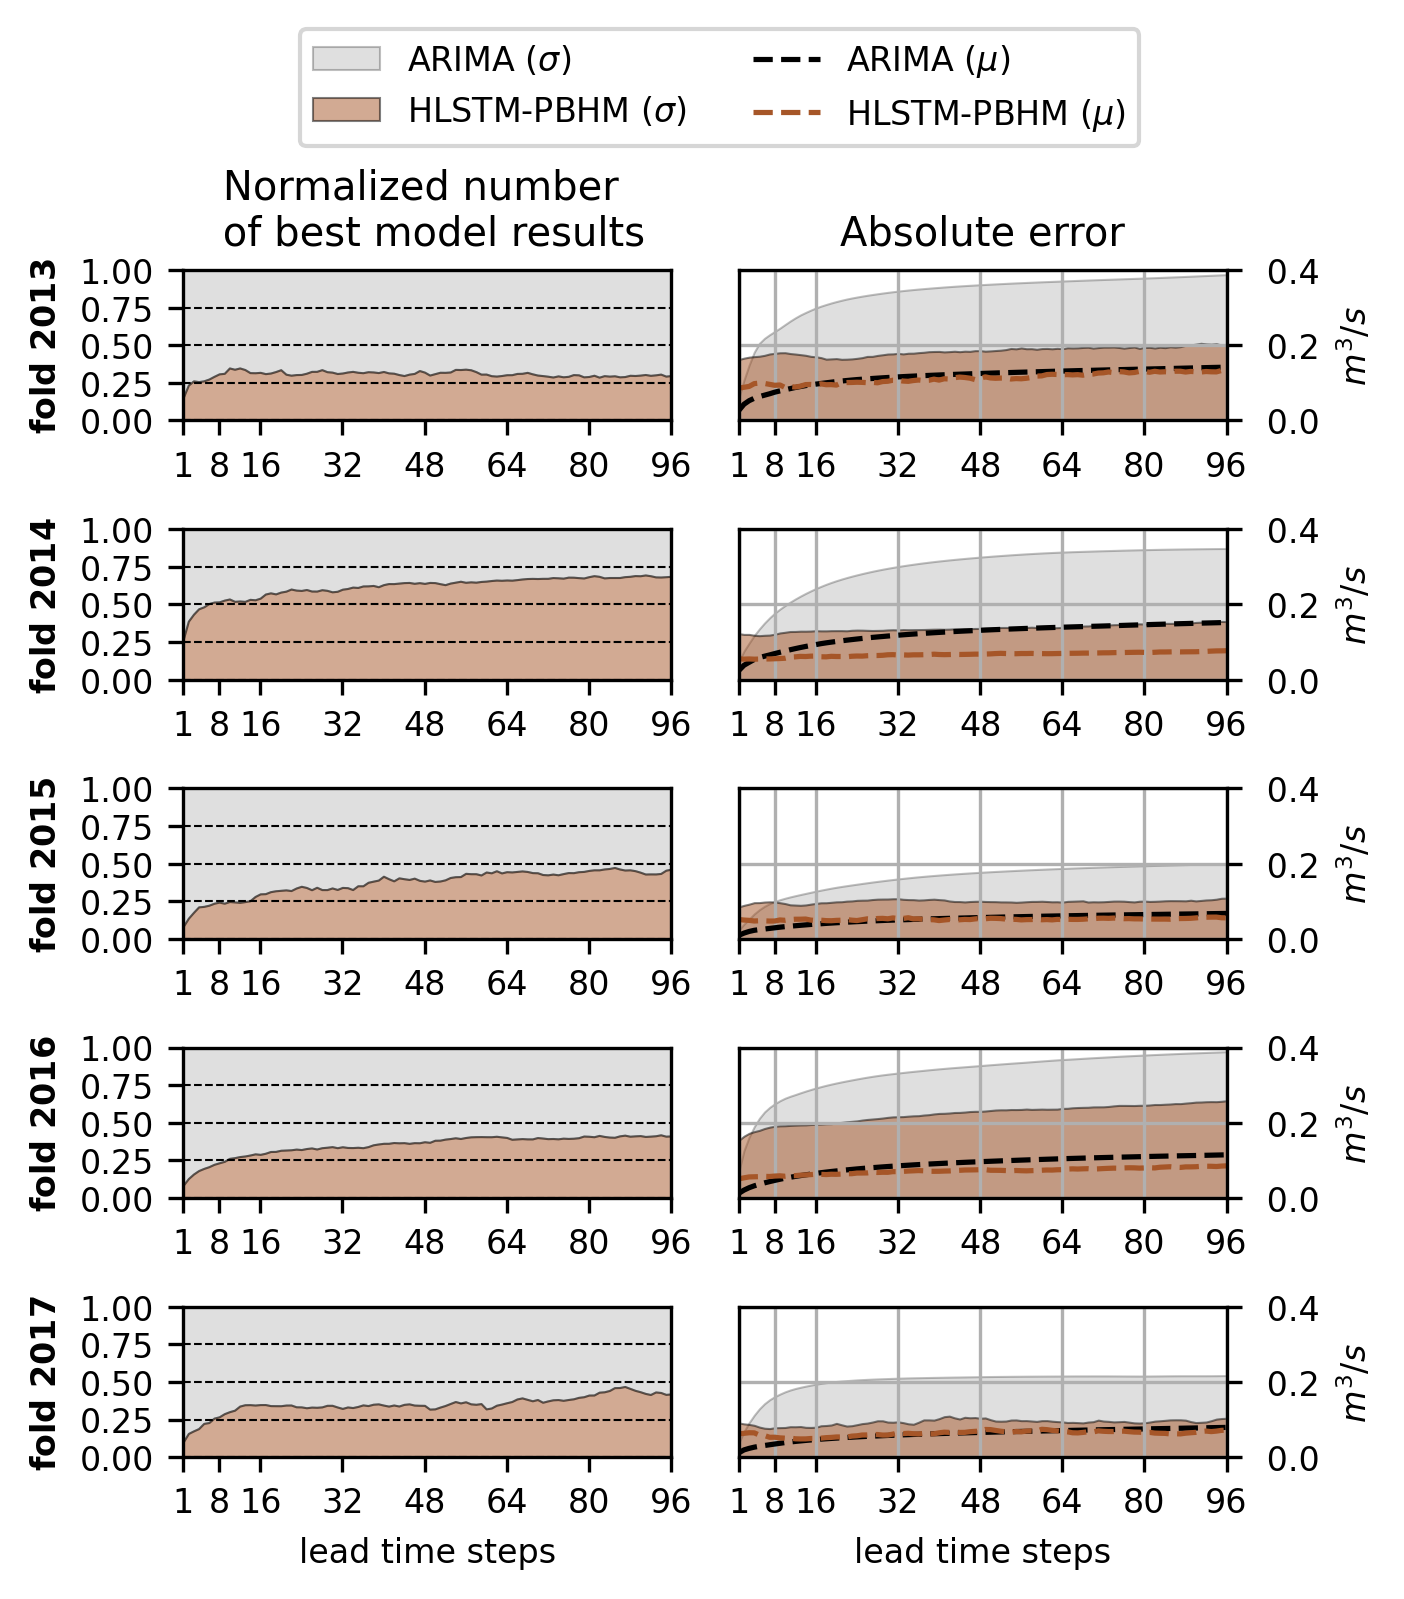

In [25]:
# process all folds
filepaths_lstm = [os.path.join(models["lstm_pbhm"].lg_path, f"forecast_{x:d}.pckl") for x in range(2013,2018)]

filepaths_arima = [os.path.join(models["arima"].lg_path, f"forecast_{x:d}.pckl") for x in range(2013,2018)]

date_ranges = [['2013-01-06 00:00:00','2013-12-27 00:00:00'],
               ['2014-01-06 00:00:00','2014-12-27 00:00:00'],
               ['2015-01-06 00:00:00','2015-12-27 00:00:00'],
               ['2016-01-06 00:00:00','2016-12-27 00:00:00'],
               ['2017-01-06 00:00:00','2017-12-27 00:00:00']]

all_error_folds_arima = []
all_error_folds_lstm = []
all_norm_arima = []
all_norm_hydro = []
all_norm_lstm = []

for i in range(0,len(filepaths_lstm)):

    data_lstm = pd.read_pickle(filepaths_lstm[i])
    data_arima = pd.read_pickle(filepaths_arima[i])

    data_lstm_filtered = data_lstm.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]
    data_arima_filtered = data_arima.sort_index().loc[date_ranges[i][0]:date_ranges[i][1]]

    all_best_list, normalized_arima, normalized_lstm, all_errors_arima, all_errors_lstm = find_best_models(data_lstm_filtered, data_arima_filtered)

    all_error_folds_arima.append(all_errors_arima)
    all_error_folds_lstm.append(all_errors_lstm)
    all_norm_arima.append(normalized_arima)
    all_norm_lstm.append(normalized_lstm)
 
fig, axes = plt.subplots(5,2,figsize=(4.72,5), dpi=300)

num_entries = 96

x_values = np.arange(1,97)

k = 0
for i in range(0,5):
        
    x = np.arange(1,97)
    y_mean = np.asarray([np.mean(elem) for elem in all_error_folds_arima[k]])
    y_std = np.asarray([np.std(elem) for elem in all_error_folds_arima[k]])
    
    y_mean_lstm = np.asarray([np.mean(elem) for elem in all_error_folds_lstm[k]])
    y_std_lstm = np.asarray([np.std(elem) for elem in all_error_folds_lstm[k]])
    
    axes[i,1].plot(x, y_mean, color='black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std, y2=0,  color='grey', label='ARIMA', alpha=0.25, edgecolor='black', linewidth=0.5)
    
    axes[i,1].plot(x, y_mean_lstm, color='#a65628', linestyle = '--', label='LSTM-PBHM ($\mu$)', linewidth=1.25)
    axes[i,1].fill_between(x, y_std_lstm, y2=0, color='#a65628', label='HLSTM-PBHM', alpha=0.5, edgecolor='black', linewidth=0.5)
    
    axes[i,1].set_xticks(np.array([1,8,16,32,48,64,80,96]))
    axes[i,1].set_yticks(np.array([0.0,0.2,0.4]))
    axes[i,1].set_ylim(0,0.4)
    axes[i,1].set_xticks(np.array([1, 8, 16, 32, 48, 64, 80, 96]))
    #axes[i, j].set_ylim(-0.05, 1.05)
    axes[i,1].set_xlim(1, 96)
    #axes[i,j].set_yticks([0, 0.25,0.5,0.75,1.0])
    axes[i,1].grid()
    
    axes[i,1].yaxis.set_major_formatter('{x: 4.1f}')
    axes[i,1].set_ylabel("$m^3/s$")
    axes[i,1].yaxis.set_label_position("right")
    axes[i,1].yaxis.set_ticks_position("right")
    
    k += 1
    
k = 0
for i in range(0,5):
   
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=1, label='ARIMA ($\sigma$)', color = 'grey',edgecolor='black', linewidth=0.5, alpha=0.25)
    axes[i,0].fill_between(x_values, y1=all_norm_lstm[k], y2=0, label='HLSTM-PBHM ($\sigma$)', color = '#a65628',edgecolor='black', linewidth=0.5, alpha=0.5)

    axes[i,0].plot([], [], color= 'black', linestyle = '--', label='ARIMA ($\mu$)', linewidth=1.25)
    axes[i,0].plot([], [], color= '#a65628', linestyle = '--', label='HLSTM-PBHM ($\mu$)', linewidth=1.25)

    axes[i,0].set_ylabel(r"$\bf{"+f"fold\ {2013 + i}"+r"}$")
    axes[i,0].set_xticks(np.array([1,8,16,32,48,64,80,96]))
    axes[i,0].set_ylim(0,1)
    axes[i,0].set_xticks(np.array([1, 8, 16, 32, 48, 64, 80, 96]))
    axes[i,0].set_ylim(0, 1)
    axes[i,0].set_xlim(1, 96)
    axes[i,0].set_yticks([0, 0.25,0.5,0.75,1.0])
    axes[i,0].grid(axis='y', linestyle='--', color='black', linewidth=0.5)

    k += 1

axes[4,0].set_xlabel('lead time steps')
axes[4,1].set_xlabel('lead time steps')
axes[0,0].set_title('Normalized number \n of best model results')
axes[0,1].set_title("Absolute error")

plt.tight_layout()
plt.subplots_adjust(top=0.89)
axes[0,0].legend(bbox_to_anchor=(1.1, 1.6),
                 # title=r'$\bf{Direct \ comparison \ between \ correction \ schemes \ - \ Overall}$',
                  loc='lower center', ncol=2, 
                  borderaxespad=1)

In [26]:
fig.savefig(os.path.join(PLOT_PATH, 'fig6_directandband_annual_ae.png'), bbox_inches="tight")